# Fit Example Using CMAES From `pints`

This example shows how to apply [CMAES](https://pints.readthedocs.io/en/stable/optimisers/cmaes.html) from [`pints`](https://github.com/pints-team/pints) to the linear interpolant provided by `nevis`, so as to find the global maximum (Ben Nevis) on the GB height map.

## Optimisation

Install `pints` if needed:

In [ ]:
%pip install -e git+https://github.com/pints-team/pints.git#egg=pints

Ensure that you have downloaded the OS Terrain data:

In [2]:
import nevis
nevis.download_os_terrain_50()
nevis.howdy() # Print the current version number

Downloaded, unpacked, and processed file already found: Skipping.

                |>          
 Starting Ben   |   Nevis   
               / \    version
            /\/---\     0.1.0
           /---    \/\      
        /\/   /\   /  \     
     /\/  \  /  \_/    \    
    /      \/           \   


First, we load the linear interpolant on the GB height data from `nevis`. The interpolant takes two arguments, the coordinates x and y, and returns a scalar height. We then get the dimensions of the data, later used as bounds for optimisation.

In [3]:
f = nevis.linear_interpolant()
x_max, y_max = nevis.dimensions()

We create an `Error` class for `pints` to minimise, and visited points will be stored in `points`. Means per iteration will be stored in `trajectory`, for which purpose a callback is defined.

Note that optimisers like CMA-ES don't treat the "best seen" point as the "best" point. Instead, they have an estimate of where the optimum should be. This is a good strategy for noisy data, but perhaps not here. You can choose which strategy to use by setting the value of `x_best`.

In [4]:
import pints

# Visited points, and means per iteration
points = []
trajectory = []

# Use best found, instead of best guessed
x_best = False


# Create pints error measure
class Error(pints.ErrorMeasure):
    """
    Turn a height into an error to be minimised.

    Writes to global var: not suitable for parallelistion!
    """
    def __init__(self, spline):
        self.f = spline

    def n_parameters(self):
        return 2

    def __call__(self, p):
        points.append(p)
        return -self.f(*p)


# Create callback to store means
def cb(i, opt):
    trajectory.append(opt.x_best() if x_best else opt.x_guessed())

Next, we optimise the interpolant using CMAES by using [`pints.OptimisationController`](https://pints.readthedocs.io/en/stable/optimisers/running.html). We randomly select a point on the map as the starting point `x0`, and the initial standard deviation around `x0` is set as half of the lower dimension size. The maximum iteration number with unchanged function value is set to 100.

In [5]:
b = pints.RectangularBoundaries([0, 0], [x_max, y_max])

e = Error(f)
x0 = b.sample()
s0 = min(b.range()) / 2
opt = pints.OptimisationController(
    e,
    x0=x0,
    sigma0=s0,
    boundaries=b,
    method=pints.CMAES
)
opt.set_callback(cb)
opt.set_max_unchanged_iterations(100, threshold=0.01)
opt.set_f_guessed_tracking(not x_best)
x1, f1 = opt.run()

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time    
0     6      0.0248    0.0248     0:00.1
1     12    -169.8889 -169.8889   0:00.1
2     18    -423.4995 -423.4995   0:00.1
3     24    -423.4995  0.621      0:00.1
20    126   -962.5701 -816.3392   0:00.1
40    246   -1222.175 -1222.175   0:00.1
60    366   -1285.613 -1284.467   0:00.1
80    486   -1293.551 -1293.551   0:00.1
100   606   -1293.696 -1293.695   0:00.1
120   726   -1293.7   -1293.7     0:00.1
140   846   -1293.7   -1293.7     0:00.1
160   966   -1293.7   -1293.7     0:00.1
180   1086  -1293.7   -1293.7     0:00.1
198   1188  -1293.7   -1293.7     0:00.1
Halting: No significant change for 100 iterations.


We then obtain the solution point and its corresponding function value. To find out where the optimiser has taken us to, we print the formatted result:

In [6]:
# Get final result
x, y = x1
nevis.print_result(x, y, -f1)

Congratulations!
You landed at an altitude of 1294m.
  https://opentopomap.org/#marker=15/57.078398/-3.728443
You are 10m from the nearest named hill top, "Braeriach",
  ranked the 3rd highest in GB.


We also print the total number of function evaluations for benchmarking:

In [7]:
print(f'Number of function evaluations: {len(points)}.')

Number of function evaluations: 1188.


## Plot

Some preparations for plotting the optimisation results:

In [8]:
import numpy as np
# Visited points
points = np.array(points)
trajectory = np.array(trajectory)
c = nevis.Coords(gridx=x, gridy=y)
h, d = nevis.Hill.nearest(c)

Figure 1: A full map with your location and visted points:

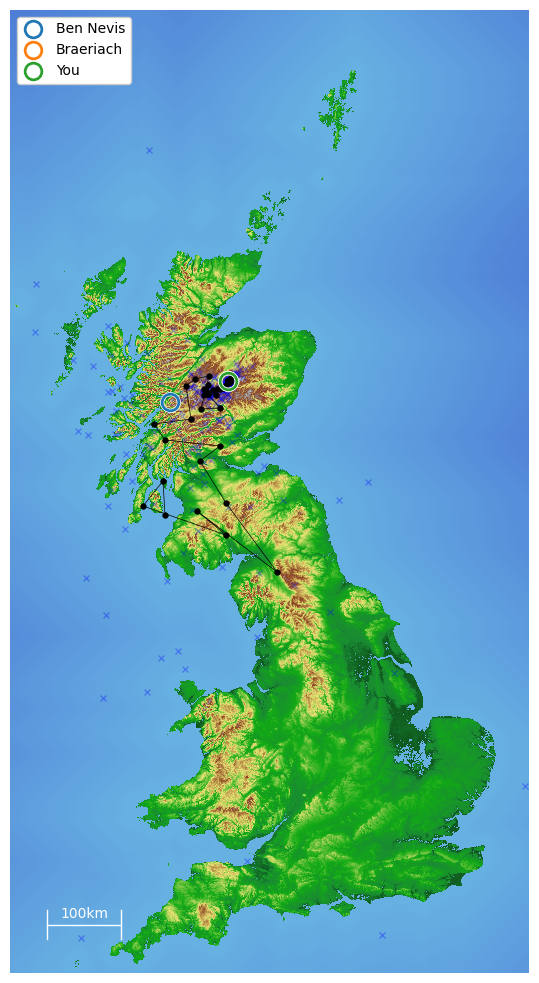

In [9]:
import matplotlib.pyplot as plt
labels = {
    'Ben Nevis': nevis.ben(),
    h.name: h.coords,
    'You': c,
}
nevis.plot(
    labels=labels,
    trajectory=trajectory,
    points=points,
)
plt.show()

Figure 2: A zoomed map with your location and visted points:

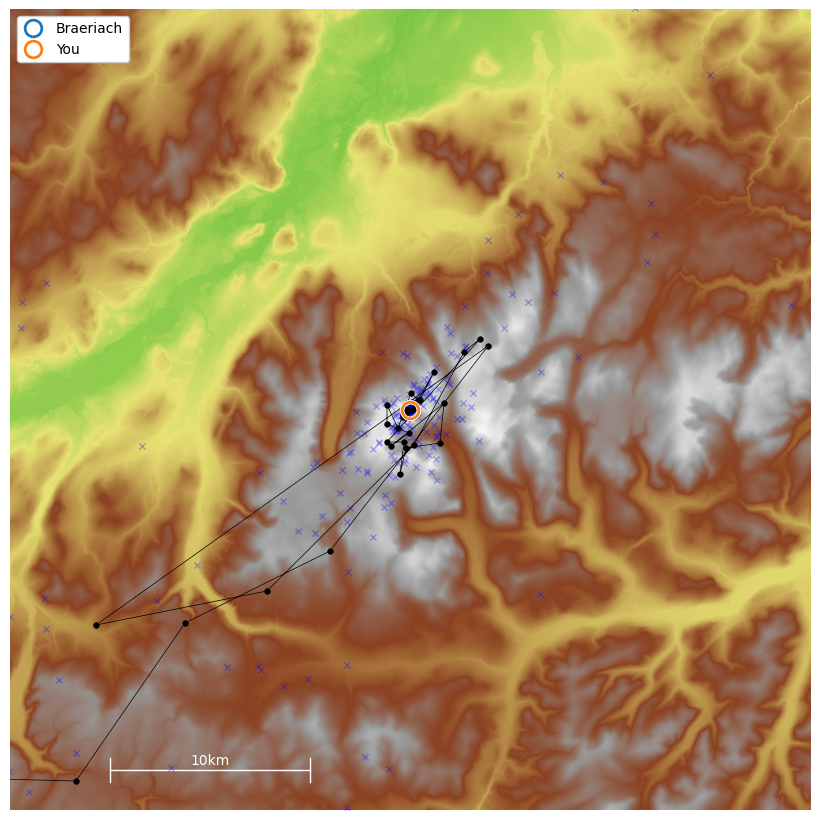

In [10]:
b = 20e3
boundaries = [x - b, x + b, y - b, y + b]
labels = {
    'Ben Nevis': nevis.ben(),
    h.name: h.coords,
    'You': c,
}
nevis.plot(
    boundaries=boundaries,
    labels=labels,
    trajectory=trajectory,
    points=points,
    zoom=1,
)
plt.show()

Figure 3: Height along the line from the nearest hill to your location (note that there might be some discrepancies between a local maximum point of the interpolant from the 50m x 50m data grid and the corresponding hill location in the database):

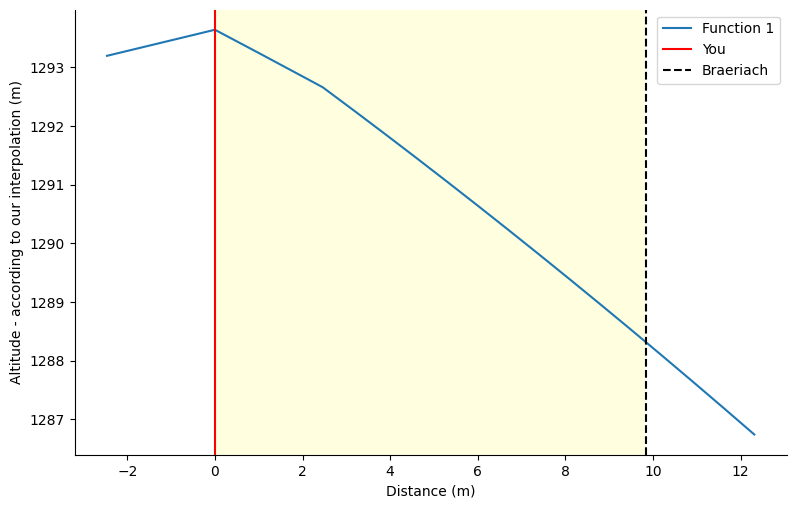

In [11]:
nevis.plot_line(f, c, h.coords, 'You', h.name)
plt.show()